### Kernel Density Estimation

In [1]:
from Utilities.utils import read_data

In [4]:
url = 'https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt'
raw, names = read_data(url)

c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ML\GammaRayBursts\Utilities\utils.py:21: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  raw = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [5]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [6]:
import numpy as np

In [9]:
T90 = np.log10(np.array([float(a) for a in raw[12] if a != '-999' and float(a) != 0]))

In [10]:
import matplotlib.pyplot as plt
from Utilities import plot_settings

Text(0, 0.5, 'Density')

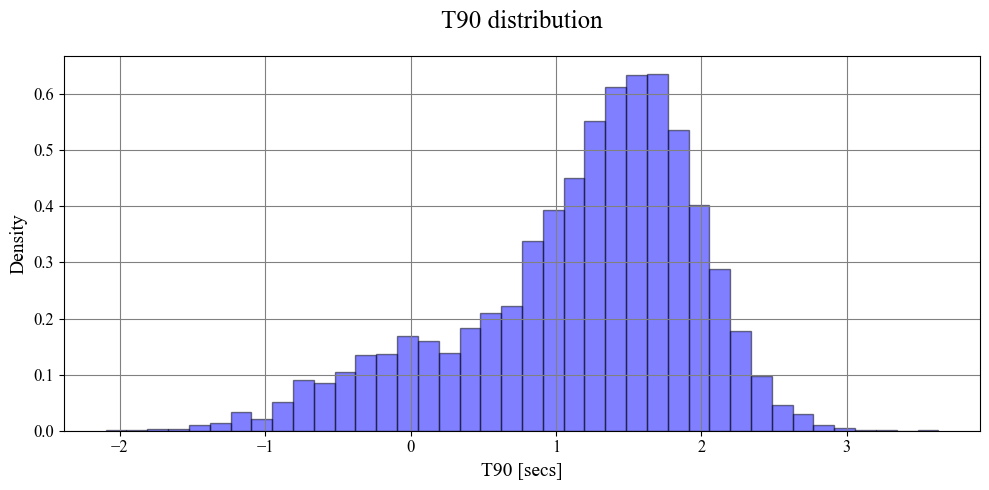

In [11]:
T90c, T90b, _ = plt.hist(T90, bins='scott', density=True, 
                         histtype='barstacked', edgecolor='black', color='blue', alpha=0.5) 
plt.title('T90 distribution')
plt.xlabel('T90 [secs]')
plt.ylabel('Density')

In [12]:
from sklearn.neighbors import KernelDensity

In [13]:
import numpy as np

In [14]:
X = T90.reshape((-1,1))

In [21]:
bandwidths = np.linspace(0.1,1,10)

In [22]:
from Utilities.utils import KDE_LOO, cross_validation_LOO

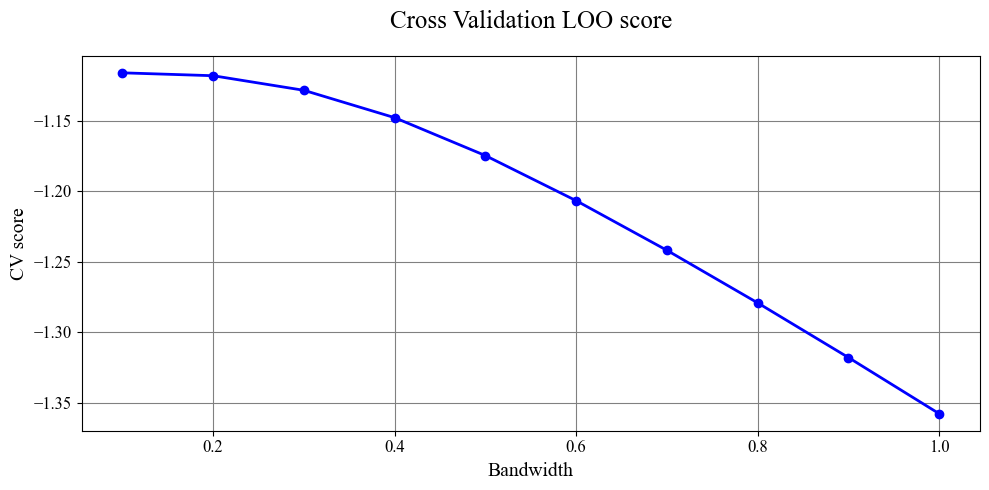

In [23]:
scores, best, best_bw = cross_validation_LOO(X, bandwidths, True)

In [24]:
xgrid = np.linspace(np.array(T90).min(), np.array(T90).max(),1000)

def kde_sklearn(data, bandwidth, kernel="gaussian"):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf), kde_skl

In [25]:
pdf, kde = kde_sklearn(np.array(T90), 0.1)

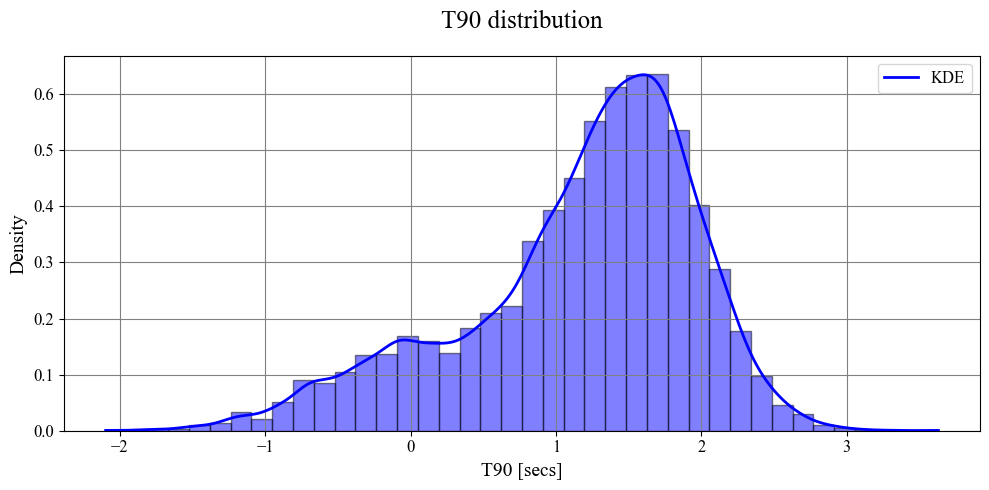

In [26]:
plt.plot(xgrid, pdf, color='blue', linewidth=2, label='KDE')
plt.hist(T90, bins='scott', density=True, histtype='barstacked', edgecolor='black', color='blue', alpha=0.5) 
plt.title('T90 distribution')
plt.xlabel('T90 [secs]')
plt.ylabel('Density')
plt.legend()

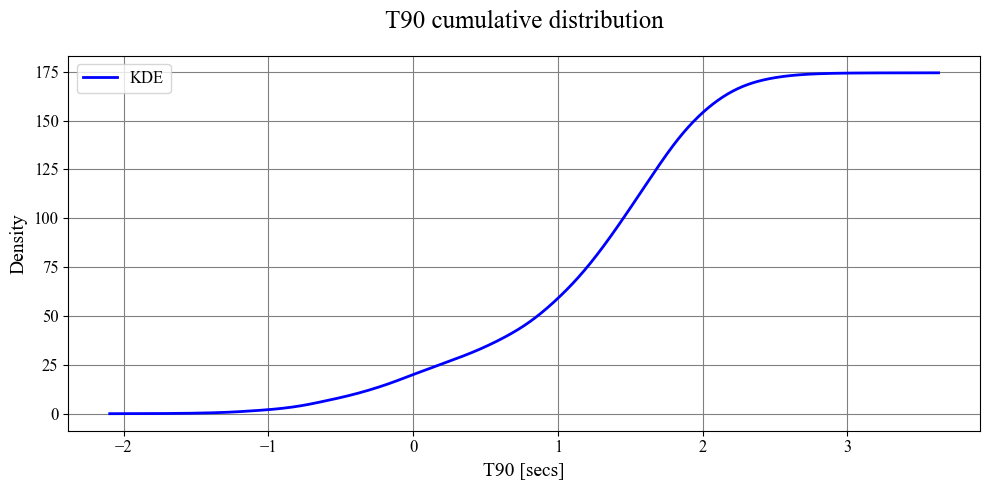

In [27]:
plt.plot(xgrid, np.cumsum(pdf), color='blue', linewidth=2, label='KDE')
plt.title('T90 cumulative distribution')
plt.xlabel('T90 [secs]')
plt.ylabel('Density')
plt.legend()

In [28]:
import scipy.stats

In [29]:
print('T90 Mean: ',T90.mean())
print('T90 Std: ', T90.std())
print('T90 mode:', scipy.stats.mode(T90).mode)
print('T90 max: ', T90.max())
print('T90 min: ', T90.min())

T90 Mean:  1.1619479730353528
T90 Std:  0.8101679647685435
T90 mode: -0.7166987712964504
T90 max:  3.6300615706748203
T90 min:  -2.0969100130080562


## Gaussian Mixture

In [30]:
from sklearn.mixture import GaussianMixture

In [31]:
ns = np.arange(1,20,1)

In [32]:
aic = np.zeros_like(ns)
bic = np.zeros_like(ns)
for n in ns:
    GM = GaussianMixture(n_components=n)
    GM.fit(X)
    aic[n-min(ns)] = GM.aic(X)
    bic[n-min(ns)] = GM.bic(X)

Text(0.5, 1.0, 'Score vs components number')

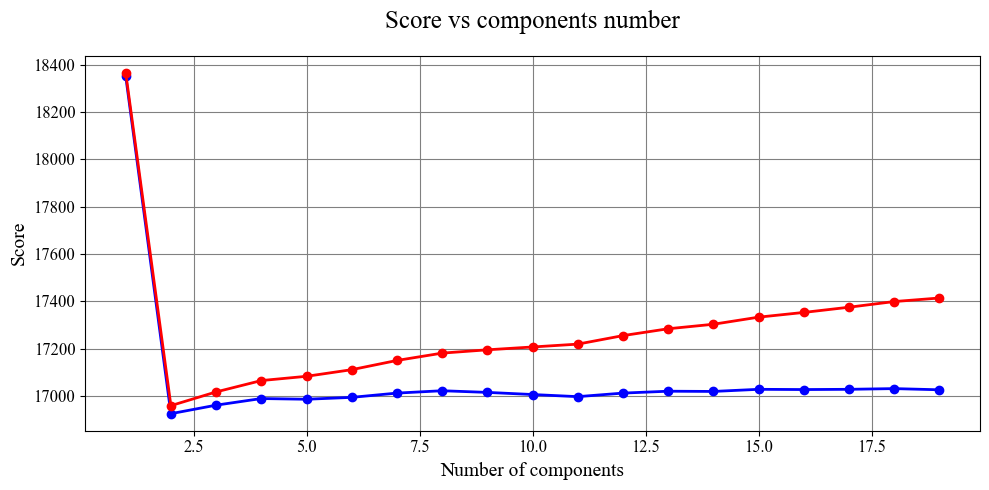

In [33]:
plt.plot(ns, aic, marker='o', color='blue', linewidth=2, label='AIC')
plt.plot(ns, bic, marker='o', color='red', linewidth=2, label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('Score vs components number')

In [34]:
GM = GaussianMixture(n_components=2)
GM.fit(X)

GaussianMixture(n_components=2)

In [35]:
x = np.linspace(X.min() - 0.5, X.max() + 0.5, 1000).reshape(-1, 1)

In [36]:
from scipy.stats import norm

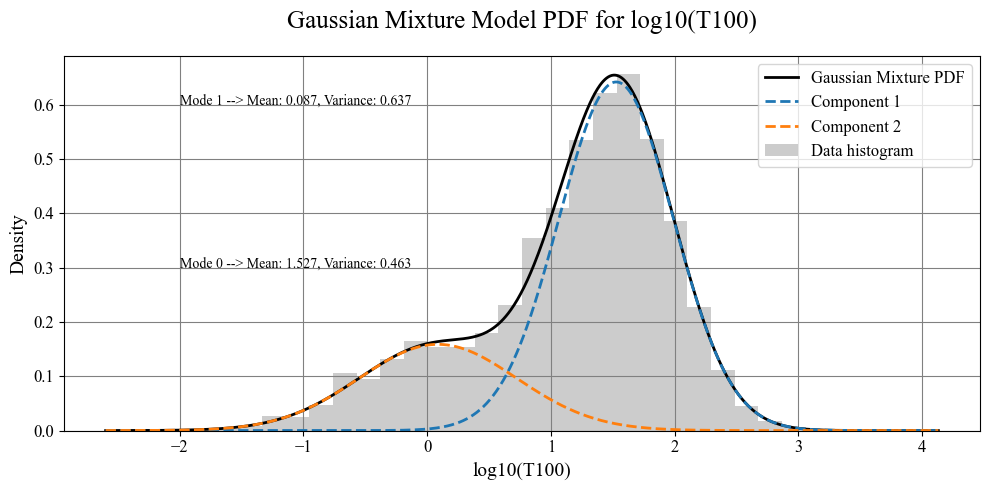

In [47]:
# Compute the weighted sum of PDFs from each Gaussian component
logprob = GM.score_samples(x)
pdf = np.exp(logprob)

# Plot the overall PDF
plt.plot(x, pdf, label='Gaussian Mixture PDF', color='black')

# Optionally plot the individual Gaussians
for i in range(GM.n_components):
    mean = GM.means_[i, 0]
    std = np.sqrt(GM.covariances_[i, 0, 0])
    weight = GM.weights_[i]
    component_pdf = weight * norm.pdf(x, mean, std)
    plt.plot(x, component_pdf, '--', label=f'Component {i+1}')
    plt.text(-2, 0.3*(1+i), 
                f'Mode {i} --> Mean: {mean:.3f}, Variance: {std:.3f}')
# Add original data histogram for context
plt.hist(X, bins=30, density=True, alpha=0.4, color='gray', label='Data histogram')

plt.xlabel('log10(T100)')
plt.ylabel('Density')
plt.title('Gaussian Mixture Model PDF for log10(T100)')
plt.legend()

In [38]:
print(f'Short GRBs T90 centroid: {np.power(10,GM.means_[0, 0]):.3f} +/- {np.sqrt(GM.covariances_[0, 0, 0])*np.power(10,GM.means_[0, 0]):.3f} seconds')
print(f'Long  GRBs T90 centroid: {np.power(10,GM.means_[1, 0]):.3f} +/- {np.sqrt(GM.covariances_[1, 0, 0])*np.power(10,GM.means_[1, 0]):.3f} seconds')

Short GRBs T90 centroid: 33.688 +/- 15.614 seconds
Long  GRBs T90 centroid: 1.221 +/- 0.778 seconds


In [39]:
from scipy.optimize import brentq

In [40]:
pdf1 = lambda x: GM.weights_[0] * norm.pdf(x, GM.means_[0, 0], np.sqrt(GM.covariances_[0, 0, 0]))
pdf2 = lambda x: GM.weights_[1] * norm.pdf(x, GM.means_[1, 0], np.sqrt(GM.covariances_[1, 0, 0]))

In [41]:
diff12 = lambda x: pdf1(x) - pdf2(x)

In [42]:
threshold_12 = brentq(diff12, GM.means_[0, 0], GM.means_[1, 0])

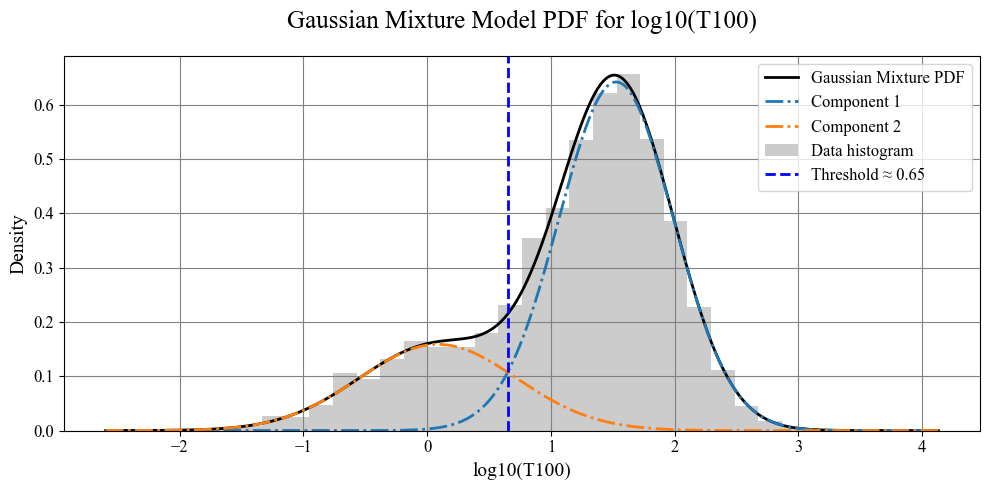

In [45]:
plt.plot(x, pdf, label='Gaussian Mixture PDF', color='black')

# Optionally plot the individual Gaussians
for i in range(GM.n_components):
    mean = GM.means_[i, 0]
    std = np.sqrt(GM.covariances_[i, 0, 0])
    weight = GM.weights_[i]
    component_pdf = weight * norm.pdf(x, mean, std)
    plt.plot(x, component_pdf, '-.', label=f'Component {i+1}')

# Add original data histogram for context
plt.hist(X, bins=30, density=True, alpha=0.4, color='gray', label='Data histogram')
plt.axvline(threshold_12, color='blue', linestyle='--', label=f'Threshold ≈ {threshold_12:.2f}')
plt.xlabel('log10(T100)')
plt.ylabel('Density')
plt.title('Gaussian Mixture Model PDF for log10(T100)')
plt.legend()

In [46]:
print(f'T100 treshold: {np.power(10, threshold_12):.3f} sec')

T100 treshold: 4.474 sec
